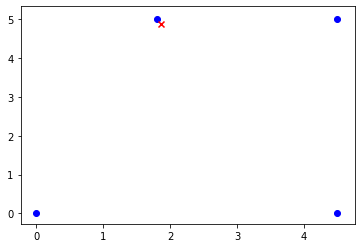

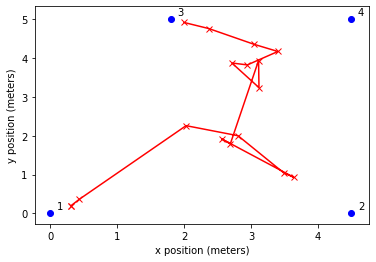

... Finished ...


In [4]:

# Indoor Positioning 
# Using BLE beacons to locate phone
# ECE M202A Final Project - Max Gong - Fall 2020

#########################################################################################################


import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import math
from scipy.optimize import minimize
from IPython.display import display, clear_output

import socket

#########################################################################################################
## PARAMETERS TO CHANGE                                  

readFile = 1      # 0 if want UDP
printTrue = 1

dataNumber = 11
fileNamebeaconLocations = 'beaconLocations' + str(dataNumber) + '.txt'
# fileNamebeaconLocations = 'beaconLocationsReference11.txt'

printNumber = 8
fileNameRaw      = 'rawRSSI' + str(printNumber) + '.txt'
fileNamePhoneMap = 'phoneMap' + str(printNumber) + '.txt'
# fileNamePhoneMap = 'phoneMap' + str(printNumber) + 'reference.txt'


#########################################################################################################

PORT = 12345            # arbitrary, just make it match in Android code
IP = "0.0.0.0"          # represents IP address of phone

# BeaconLocations = [(0,0), (3.24,0.75), (3.24,1.84), (0,1.84)]          # test coordinates of beacon locations in my room (in meters)

dataBeacons = np.loadtxt(fileNamebeaconLocations)
BeaconIDs = dataBeacons[:,0]
BeaconLocations = dataBeacons[:,[1,2]]
numOfBeacons = len(BeaconIDs)
distances = np.zeros(numOfBeacons) + 5             # The distances of phone to beacon (in meters). We initialize with 10 meters to assume they're far away.
initial_location_index = 0                         # Educated guess of initial_location to begin trilateration optimization
pathTrace = np.asarray([[0,0]])
calibrationMax = 3                                 # Number of initial path data to omit
calibrationCount = 0
 

#########################################################################################################
   
## Listen UDP messages
def listen_udp():
    msg_IP_content, addr = sock.recvfrom(1024)      # buffer size is 1024 bytes
    msg_IP_content = msg_IP_content.decode("utf-8")
    return msg_IP_content

    
## Parse UDP-received message into data
def parse(msg_IP_content): 
    data = np.asarray(msg_IP_content.split(","))
    size_data = len(data)
    BeaconDetectedIDs = np.empty( int((size_data - 1) / 2), dtype=int ) 
    BeaconDetectedRSSIs = np.empty( int((size_data - 1) / 2), dtype=float ) 
    for i in range(len(data)):
        if i == 0:
            AndroidID = data[i]
        elif i%2 == 1:
            index = int(i/2)
            BeaconDetectedIDs[index] = int(data[i])
        else:
            BeaconDetectedRSSIs[int(i/2)-1] = float(data[i])
    return BeaconDetectedIDs, BeaconDetectedRSSIs
        

## Estimate distance based on RSSI
def estimate_distance(distances, initial_location_index, BeaconDetectedIDs, BeaconDetectedRSSIs):
    filterFactor = 0.2
    for i in range(len(BeaconDetectedIDs)):
        tempIndex = np.where(BeaconIDs==BeaconDetectedIDs[i])
        tempDistance = 10**( (-59-BeaconDetectedRSSIs[i]) / (10*4) )     # Calculate distance Blue Charm beacon's measured RSSI is -59 dBm at 1 meter. Assume environmental factor = 2
        distances[tempIndex] = filterFactor*distances[tempIndex] + (1-filterFactor)*tempDistance     # Low pass filter RSSI 
        if distances[tempIndex] < distances[initial_location_index]:                             # define initial_location_index for MSE
            initial_location_index = tempIndex
    return distances, initial_location_index
    

## Locate phone using trilateration optimization
def estimate_location(distances, initial_location_index, BeaconLocations, pathTrace):                                          # only calculate distance when beacons are detected
    initial_location = BeaconLocations[initial_location_index]   # Define initial location for trilateration minimization
    result = minimize(               # Trilateration that minimizes MSE - https://www.alanzucconi.com/2017/03/13/positioning-and-trilateration/
        mse,                         # The error function
        initial_location,            # The initial guess --> phoneLocation will equal this at first
        args=(BeaconLocations, distances), # Additional parameters for mse
        method='L-BFGS-B',           # The optimisation algorithm
        options={
        'ftol':1e-5,         # Tolerance
        'maxiter': 1e+7      # Maximum iterations
    })
    phoneLocation = result.x
    phoneLocation = filter_phone_location(phoneLocation, pathTrace, 0.5)
    return phoneLocation


## Locate phone with pondering -- "Improving bluetooth beacon-based indoor location and fingerprinting"
def estimate_location_2(distances, BeaconLocations, pathTrace):
    tempLocation = np.asarray([0,0])
    pSum = 0
    for i in np.arange(BeaconLocations.shape[0]):
        p = 1/distances[i]**2
        pSum += p
        tempLocation = tempLocation + BeaconLocations[i]*p
    tempLocation = tempLocation / pSum
    return tempLocation


## LPF phone location
def filter_phone_location(phoneLocation, pathTrace, filterFactor):
    phoneLocation = filterFactor*pathTrace[pathTrace.shape[0]-1,:] + (1-filterFactor)*phoneLocation
    return phoneLocation


## Map phone position + beacons
def map_phone(phoneLocation, BeaconIDs, BeaconLocations):
    fig = plt.figure()
    for i in np.arange(len(BeaconIDs)):
        plt.scatter(BeaconLocations[i][0], BeaconLocations[i][1], c="blue")
    plt.scatter(phoneLocation[0], phoneLocation[1], c="red", marker="x")
    display(fig)
    clear_output(wait = True)
    plt.pause(0.02)

    
## Record path
def record_path(pathTrace, phoneLocation, calibrationCount, calibrationMax):
    if calibrationCount >= calibrationMax:
        pathTrace = np.vstack((pathTrace, phoneLocation))
    else:
        pathTrace = phoneLocation
        calibrationCount += 1
    return pathTrace, calibrationCount

    
## Map path
def map_path(pathTrace, BeaconIDs, BeaconLocations):
    if pathTrace.shape[0] > 3:
        tempIndex = pathTrace.shape[0]-1
        pathTrace = pathTrace[2:tempIndex, :]                 # ignore the 1st three data points, as they're meant for calibration
        for i in np.arange(len(BeaconIDs)):
            plt.scatter(BeaconLocations[i][0], BeaconLocations[i][1], c="blue")
            plt.annotate(str(int(BeaconIDs[i])), (BeaconLocations[i][0]+0.1, BeaconLocations[i][1]+0.1))   # annotate IDs
        xPos = pathTrace[:,0]          # 1st column = x
        yPos = pathTrace[:,1]          # 2nd column = y
        plt.plot(xPos, yPos, c="red", marker="x")
        plt.xlabel('x position (meters)')
        plt.ylabel('y position (meters)')
        plt.show()
    else:
        print("... NO POSITIONS TO MAP ...")
        

## Write path to file
def write_path_to_file(pathTrace, fileNamePhoneMap):
    filePhoneMap = open(fileNamePhoneMap,"w")
    for row in np.arange(pathTrace.shape[0]):
        filePhoneMap.write(str(pathTrace[row,0])+" "+str(pathTrace[row,1])+"\n")
    filePhoneMap.close()

    
###############################################################################################################
        
## Define function to calculate MSE for trilateration - https://www.alanzucconi.com/2017/03/13/positioning-and-trilateration/
def mse(phoneLocation, locations, distances):
    mse = 0.0
    for location, distance in zip(locations, distances):
        distance_calculated = calculateDistance(phoneLocation[0], phoneLocation[1], location[0], location[1])
        mse += math.pow(distance_calculated - distance, 2.0)
    return mse / len(distances)

def calculateDistance(x1,y1,x2,y2):
    return np.sqrt( (x1-x2)**2 + (y1-y2)**2 )

    
#########################################################################################################    
if readFile == 0:
    print("... Listening for data ...")
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # UDP
    sock.bind((IP, PORT))
    fileRaw = open(fileNameRaw,"w")            # store data into file
    try:
        while True:
            msg_IP_content = listen_udp()
            if msg_IP_content.find("STOP")!=-1:
                break
            elif (msg_IP_content != "") and ("paho" in msg_IP_content):       
                fileRaw.write(msg_IP_content+"\n")
                BeaconDetectedIDs, BeaconDetectedRSSIs = parse(msg_IP_content)
                distances, initial_location_index = estimate_distance(distances, initial_location_index, BeaconDetectedIDs, BeaconDetectedRSSIs)
                #if len(BeaconDetectedIDs) > 0: 
                #phoneLocation = estimate_location(distances, initial_location_index, BeaconLocations, pathTrace)
                phoneLocation = estimate_location_2(distances, BeaconLocations, pathTrace)    # "Improving bluetooth beacon-based indoor location and fingerprinting"
                map_phone(phoneLocation, BeaconIDs, BeaconLocations)
                pathTrace, calibrationCount = record_path(pathTrace, phoneLocation, calibrationCount, calibrationMax)
                msg_IP_content = ""
    except KeyboardInterrupt:
        print("... Keyboard Interrupt ...")
    fileRaw.close()
    sock.close()
    map_path(pathTrace, BeaconIDs, BeaconLocations)
else:
    f = open(fileNameRaw, 'r')
    for line in f.readlines():
        msg_IP_content = line.replace('\n','')
        BeaconDetectedIDs, BeaconDetectedRSSIs = parse(msg_IP_content)
        distances, initial_location_index = estimate_distance(distances, initial_location_index, BeaconDetectedIDs, BeaconDetectedRSSIs)
        phoneLocation = estimate_location_2(distances, BeaconLocations, pathTrace)    # "Improving bluetooth beacon-based indoor location and fingerprinting"
        map_phone(phoneLocation, BeaconIDs, BeaconLocations)
        pathTrace, calibrationCount = record_path(pathTrace, phoneLocation, calibrationCount, calibrationMax)
        msg_IP_content = ""
    map_path(pathTrace, BeaconIDs, BeaconLocations)
    f.close()    
        
        
if printTrue == 1:
    write_path_to_file(pathTrace, fileNamePhoneMap)
print("... Finished ...")




In [32]:
a = np.asarray([[1, 2], [2, 3]])
b = np.asarray([4, 5])
print(a[a.shape[0]-1, :])
a = np.vstack()

[2 3]
(2,)
